# Supplementary Information

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
import seaborn as sns
import matplotlib.pylab as plt
import bites as bt
from os import sep
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.patches import ConnectionPatch
import matplotlib.animation as animation
from IPython.display import HTML, display

In [2]:
plt.rcParams['pdf.fonttype'] = 42

Extract data directory and metadata. 

In [3]:
dataDir = 'raw/JK_biting_paper_trained_data_04092025'
metaDat = 'video_parameters_04172025.csv'
plot_folder = r"plots/"

In [4]:
datasetDf = pd.read_csv(sep.join([dataDir, metaDat])).rename(columns={'Unnamed: 0': 'video'})
datasetDf['path'] = datasetDf['video'].apply(lambda x: sep.join([dataDir, x.replace('vid', dataDir.split(sep)[-1].split('_')[-1])]))
datasetDf['filename'] = datasetDf['video'].apply(lambda x: x.replace('vid','data')+'.csv')
datasetDf['videofile'] = datasetDf['video'].apply(lambda x: x+'.mp4')

In [5]:
undDf = pd.read_csv(sep.join([dataDir.split('/')[0], 'underskin_data.csv']))
undDfFull = pd.read_csv(sep.join([dataDir.split('/')[0], 'underskin_data_full.csv']))

## Supplementary Plots

In [6]:
expDf = pd.DataFrame()
for videoIdxI in range(len(datasetDf)):
    corrDf = bt.corrDfConstruct(videoIdxI, datasetDf, phase='late').copy()
    corrDf['videoIdx'] = videoIdxI
    expDf = pd.concat([expDf, corrDf], axis=0).reset_index(drop=True);

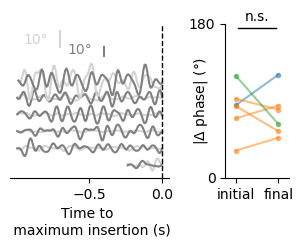

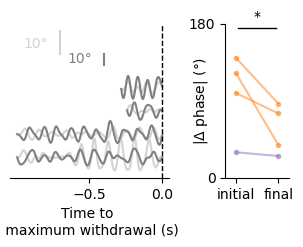

In [7]:
statDf = pd.DataFrame()
for condition in ['insertion', 'removal']:
    from scipy.signal import butter, filtfilt, hilbert
    fig, ax = plt.subplots(1,2,figsize=(3.6, 2), gridspec_kw={'width_ratios': [1, 0.4], 'wspace': 0.5})
    mask = expDf[condition] == 1
    groups = (mask != mask.shift()).cumsum()
    removal_blocks = expDf[mask].groupby(groups[mask])

    dPh_arr = np.zeros([len(removal_blocks), 2])
    for bi, block in removal_blocks:
        block = block[['time [s]', 'lab_angle', 'pal_angle', 'videoIdx']].dropna(axis=0, how='any').copy()
        t_rel = block['time [s]'].values -block['time [s]'].values[-1]  # align to end
        fs = 1/np.median(np.diff(block['time [s]'].values))
        dp1 = bt.apply_bandpass_filter(block['lab_angle'], 5, 20, fs=fs, order = 4)
        dp2 = bt.apply_bandpass_filter(block['pal_angle'], 5, 20, fs=fs, order = 4)
        ax[0].plot(t_rel, dp1*2+bi*10, color='lightgrey')
        ax[0].plot(t_rel, dp2+bi*10, color='grey')
        dPh_arr[bi//2-1,:] = np.array([np.mean((np.rad2deg(np.abs(((np.angle(hilbert(dp1))-np.angle(hilbert(dp2)))-np.pi)%(2*np.pi)-np.pi))[t_rel<t_rel.min()+0.15])),
    np.mean((np.rad2deg(np.abs(((np.angle(hilbert(dp1))-np.angle(hilbert(dp2)))-np.pi)%(2*np.pi)-np.pi)))[t_rel>-0.15])])
        ax[1].plot([0,1], dPh_arr[bi//2-1,:],
        '.-', color = block['videoIdx'].map(lambda x: f"C{x}").values[0], alpha=0.5)


    ax[0].plot([-0.4, -0.4], [(len(removal_blocks)*2.5)*10, (len(removal_blocks)*2.5+1)*10], color='grey', linewidth=1.5)
    ax[0].plot([-0.7, -0.7], [(len(removal_blocks)*2.5+1)*10, (len(removal_blocks)*2.5+3)*10], color='lightgrey', linewidth=1.5)
    ax[0].text(-0.95, (len(removal_blocks)*2.5+1.5)*10, '10°', color='lightgrey')
    ax[0].text(-0.65, (len(removal_blocks)*2.5+0.25)*10, '10°', color='grey')
    ax[0].axvline(0, color='k', linestyle='--', linewidth=1)
    ax[0].set_xticks([-0.5, 0])
    ax[1].set_xticks([0, 1])
    ax[1].set_xlim([-0.25, 1.25])
    ax[1].set_yticks([0, 180])
    ax[1].set_xticklabels(['initial', 'final'])
    ax[1].set_ylabel(r'$|\Delta$ phase| (°)', fontsize=10, labelpad=-15)

    ax[0].set_yticks([])
    ax[0].set_ylabel(None)
    ax[0].set_xlabel(f'Time to \n maximum {condition.replace("removal", "withdrawal")} (s)')
    sns.despine(left=True, ax=ax[0])
    sns.despine(ax=ax[1])

    TtestStat, pval = sp.stats.ttest_rel(
        dPh_arr[:,0],
        dPh_arr[:,1], alternative='greater')
    
    ax[1].axhline(175, xmin=0.2, xmax=0.8, color='k', linewidth=1)
    if pval < 0.05:
        ax[1].text(0.5, 180, f'*', ha='center', va='bottom', fontsize=10)
    else:
        ax[1].text(0.5, 180, f'n.s.', ha='center', va='bottom', fontsize=10)
    
    statDf = pd.concat([statDf, pd.DataFrame({'Condition':[condition], 'T-statistic':[TtestStat], 'P-value':[pval]})], axis=0).reset_index(drop=True).round(3)
    plt.savefig(plot_folder + f'{condition}'+"_phase_shift.pdf", bbox_inches='tight', dpi=300)
statDf.to_csv(plot_folder + 'phase_shift_stats.csv', index=False)

In [8]:
statDf

,Condition,T-statistic,P-value
0,insertion,0.399,0.353
1,removal,2.381,0.049


In [9]:
p_val_array = np.zeros([2, len(expDf['videoIdx'].unique())])
H_val_array = np.zeros([2, len(expDf['videoIdx'].unique())])
for idx in expDf['videoIdx'].unique():
    for ci, condition in enumerate(['insertion', 'removal']):
        if expDf.loc[expDf['videoIdx']==idx, condition].sum()>0:
            H_val_array[ci,idx], p_val_array[ci,idx] = bt.entropyBootstrapTest(
                expDf.loc[(expDf['videoIdx']==idx)&(expDf[condition]==1), 'dPh'].dropna().values,
                expDf.loc[(expDf['videoIdx']==idx)&(expDf[condition]!=1), 'dPh'].dropna().values
            )
        else:
            p_val_array[ci,idx] = np.nan
            H_val_array[ci,idx] = np.nan
p_val_df = pd.DataFrame(p_val_array.T, columns=['insertion', 'removal'])
H_val_df = pd.DataFrame(H_val_array.T, columns=['insertion', 'removal'])

In [10]:
H_p_df = pd.concat(
    {"Circular Entropy": H_val_df, "P-value": p_val_df},
    axis=1,
    names=["Video #"]  # outer column level name
).astype(float).round(3)
H_p_df

Video # Circular Entropy           P-value        
               insertion removal insertion removal
0                  1.450     NaN     0.705     NaN
1                  1.828   1.512     0.968   0.001
2                  1.906     NaN     0.892     NaN
3                    NaN     NaN       NaN     NaN
4                    NaN   0.645       NaN   0.001

In [11]:
H_p_df.to_csv(plot_folder + 'phase_shift_entropy_stats.csv', index=True)